<a href="https://colab.research.google.com/github/mardydu/MissingPixelsProject/blob/main/Copy_of_ai_missing_pixels_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
!git clone https://github.com/dmc27/missing_pixels.git

fatal: destination path 'missing_pixels' already exists and is not an empty directory.


In [24]:
import os.path
from os import listdir
from os.path import isfile, join

import cv2 as cv

from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from keras.layers import Input, Dense,Conv2D,MaxPooling2D,UpSampling2D,BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint

NUM_INP_NODES = 60
NUM_OUT_NODES = 4
BLOCK_SIZE = 8
M1 = 3
M2 = 4
C1 = 0
C2 = 7

In [26]:
img_path = "/content/missing_pixels/"
img_fnames = [f for f in listdir(img_path) if isfile(join(img_path, f))]
print(img_fnames)

x_train = []
y_train = []
y_test = []
x_test = []

for idx in range(len(img_fnames)):
  img = cv.imread(img_path+img_fnames[idx])
  img = cv.resize(img, (64, 64), cv.INTER_LINEAR)
  img2 = cv.imread(img_path+img_fnames[idx])
  img2 = cv.resize(img, (64, 64), cv.INTER_LINEAR)
  # img = img.astype(np.float64)
  num_rows = img.shape[0]
  num_cols = img.shape[1]

  if (img == "balloon.bmp" and img2 == "balloon.bmp"):
    continue

  for r in range(num_rows):
    for c in range(num_cols):
      interval = 4
      size = 1
      x = 0
      y = 0
      while x < 64-interval:
        x += interval
      
        for i in range(size):
          while y < 64-interval:
            y += interval

            for j in range(size):
              img[x][y] = 0
              y += 1

          x += 1
          y = 0
  x_train.append(img)
  y_train.append(img2)
  # plt.figure()
  # plt.imshow(img)
  # plt.imshow(img2)
  # plt.show()

x_train = np.array(x_train)
y_train = np.array(y_train)
# print(img[0])

['eagle.bmp', 'bushes.bmp', 'KIDS.BMP', 'FOOTBALL.BMP', 'hawaii.bmp', 'baboon.bmp', 'rabbits.bmp', 'SAIL.BMP', 'cactus.bmp', 'BEACH.BMP', 'pelicans.bmp', 'bridge.bmp', 'frog.bmp', 'branches.bmp', 'balloon.bmp', 'airplane.bmp', 'peak.bmp', 'beans.bmp', 'helen.bmp', 'lena.bmp', 'TABLE.BMP', 'desert.bmp', '1fnoise.bmp', 'PUMPKINS.BMP', 'zelda.bmp', 'lily.bmp', 'horse.bmp', 'sealion.bmp', 'rooster.bmp', 'tank.bmp', 'tulips.bmp', 'birds.bmp', 'fruits.bmp', 'barbara.bmp', 'WALL.BMP', 'peppers.bmp', 'deer.bmp', 'HOUSE.BMP', 'man.bmp', 'kid.bmp', 'duck.bmp', 'bricks.bmp', 'barn.bmp', 'TRAIN.BMP', 'pony.bmp', 'FLOWERS.BMP', 'fox.bmp', 'bark.bmp', 'stream.bmp', 'buds.bmp', 'sheep.bmp', 'rainriver.bmp', 'valley.bmp', 'baby.bmp', 'dune2.bmp']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


<Figure size 432x288 with 0 Axes>

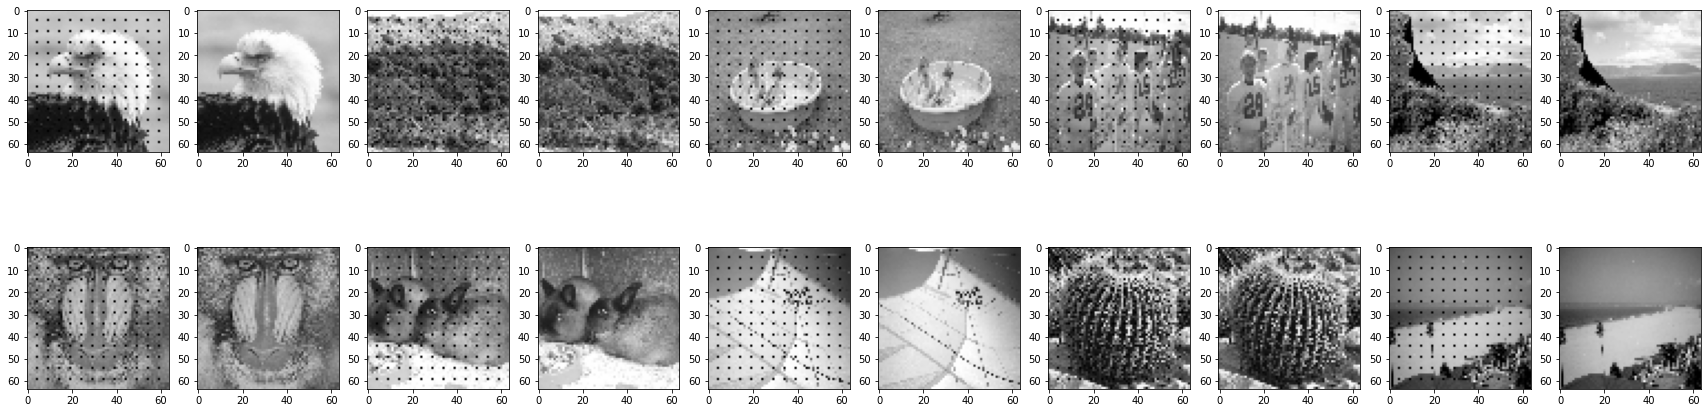

In [ ]:
plt.figure()
f, axarr = plt.subplots(2, 10, figsize=(30,8))

i = 0
j = 1
for n in range(5):
  axarr[0][i].imshow(x_train[n])  
  axarr[0][j].imshow(y_train[n])
  axarr[1][i].imshow(x_train[n+5])
  axarr[1][j].imshow(y_train[n+5])

  i += 2
  j += 2

plt.show()

In [ ]:
input_img = Input(shape=(64,64,3))

x_train = x_train.astype('float64') / 255
y_train = y_train.astype('float64') / 255
# x_test = y_test.astype('float32') / 255
# y_test = y_test.astype('float32') / 255

#Encoder
x = Conv2D(16,(3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)

x = Conv2D(8,(3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)

x = Conv2D(8,(3,3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same', name='encoder')(x)

#Decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(16, (3, 3), activation='relu',padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(64, 64, 3)))
model.add(BatchNormalization())     # 32x32x32
model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu'))      # 16x16x32
model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu'))      # 16x16x32
model.add(BatchNormalization())     # 16x16x32
model.add(UpSampling2D())
model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', activation='relu'))      # 32x32x32
model.add(BatchNormalization())
model.add(Conv2D(3,  kernel_size=1, strides=1, padding='same', activation='sigmoid'))   # 32x32x3

model.compile(optimizer='adam', metrics=['accuracy'], loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 up_sampling2d_3 (UpSampling  (None, 64, 64, 32)       0

In [ ]:
autoencoder=Model(input_img, decoded)

In [ ]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 8)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 8)         584 

In [ ]:
encoder = Model(input_img, encoded)

In [ ]:
encoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 8)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 8)         584 

In [ ]:
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=100, batch_size=32,
  validation_split=0.25)

Epoch 1/100
2/2 [==============================] - 0s 54ms/step - loss: 0.0103 - accuracy: 0.2667 - val_loss: 0.0466 - val_accuracy: 0.0142
Epoch 2/100
2/2 [==============================] - 0s 25ms/step - loss: 0.0107 - accuracy: 0.2726 - val_loss: 0.0465 - val_accuracy: 0.0174
Epoch 3/100
2/2 [==============================] - 0s 25ms/step - loss: 0.0097 - accuracy: 0.2747 - val_loss: 0.0466 - val_accuracy: 0.0196
Epoch 4/100
2/2 [==============================] - 0s 25ms/step - loss: 0.0100 - accuracy: 0.2822 - val_loss: 0.0467 - val_accuracy: 0.0213
Epoch 5/100
2/2 [==============================] - 0s 25ms/step - loss: 0.0096 - accuracy: 0.2827 - val_loss: 0.0465 - val_accuracy: 0.0234
Epoch 6/100
2/2 [==============================] - 0s 26ms/step - loss: 0.0091 - accuracy: 0.2823 - val_loss: 0.0461 - val_accuracy: 0.0251
Epoch 7/100
2/2 [==============================] - 0s 24ms/step - loss: 0.0089 - accuracy: 0.2826 - val_loss: 0.0459 - val_accuracy: 0.0274
Epoch 8/100
2/2 [===

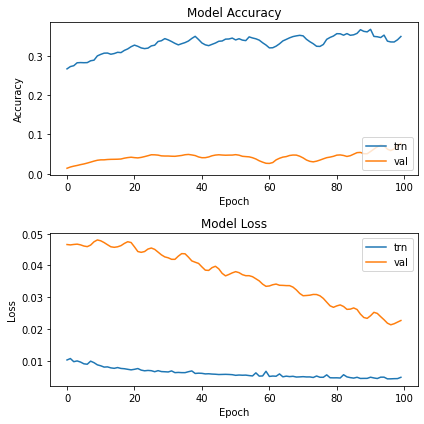

In [ ]:
fig = plt.figure(figsize=(6,6))
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['trn', 'val'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['trn', 'val'], loc='upper right')
plt.tight_layout()
